# Find Stars with Photutils &#x2728;
The main goal of this part of the workshop is to detect point sources (some of which will be stars, black holes, neutron stars, star clusters, Active Galactic Nuclei, you name it!) in an astronomical image with the `DAOStarFinder` algorithm and then extract their photometry.

## A little about the algorithm in play

1. Estimating FWHM (`RadialProfile` or `fit_fwhm`)
2. Background Estimation
3. Point Source Detection (Finding stars)
4. Aperture Photometry
5. Your turn!
6. Use case of DaoStarFinder

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Estimating FWHM

## using `RadialProfile`
measuring surface brightness against increasing aperture radius

In [2]:
from astropy.modeling.models import Gaussian2D              # to create a 2D gaussian
from astropy.visualization import simple_norm               # for image normalization
from photutils.datasets import make_noise_image             # to create a noisy image

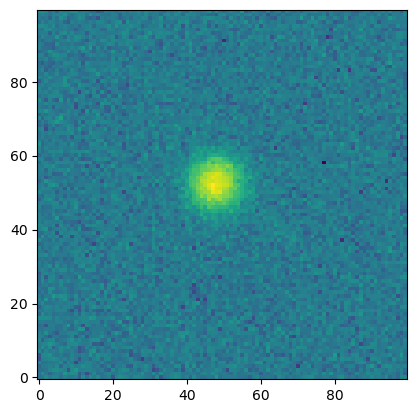

In [3]:
# create an artificial single source
gmodel = Gaussian2D(amplitude=42.1,
                    x_mean=47.8, 
                    y_mean=52.4, 
                    x_stddev=4.7, 
                    y_stddev=4.7, 
                    theta=0)       # rotational angle
yy, xx = np.mgrid[0:100, 0:100]
data = gmodel(xx, yy)
bkg_sig = 2.4
noise = make_noise_image(data.shape, mean=0., stddev=bkg_sig, seed=123)

# Add noise to the data
data += noise
error = np.zeros_like(data) + bkg_sig

norm = simple_norm(data, 'sqrt')
plt.imshow(data, origin='lower', norm=norm)

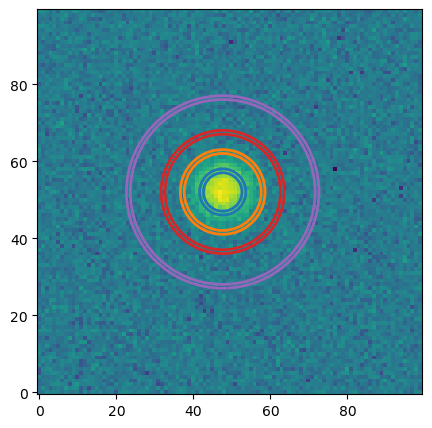

In [4]:
from photutils.centroids import centroid_quadratic          # to get the centroid position of the gaussian
from photutils.profiles import RadialProfile                

# find the source centroid
xycen = centroid_quadratic(data, xpeak=48, ypeak=52)

# create the radial profile
edge_radii = np.arange(26)
rp = RadialProfile(data, xycen, edge_radii, error=error, mask=None)

norm = simple_norm(data, 'sqrt')
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(data, norm=norm, origin='lower')
rp.apertures[5].plot(ax=ax, color='C0', lw=2)
rp.apertures[10].plot(ax=ax, color='C1', lw=2)
rp.apertures[15].plot(ax=ax, color='C3', lw=2)
rp.apertures[24].plot(ax=ax, color='C4', lw=2)
plt.show()

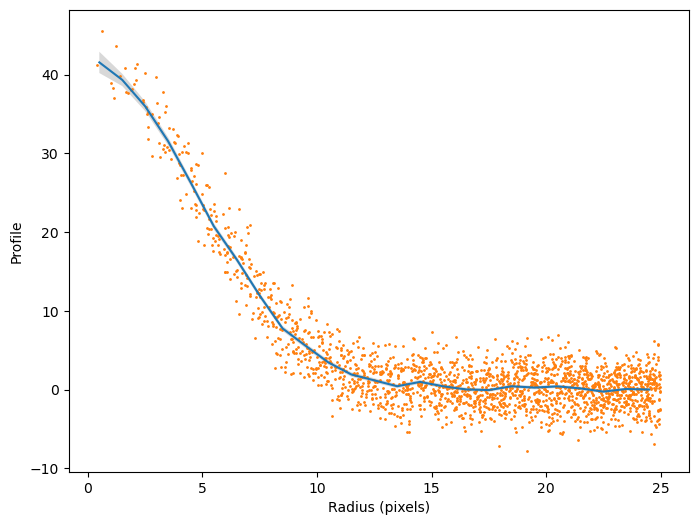

In [5]:
# plot the radial profile
fig, ax = plt.subplots(figsize=(8, 6))
rp.plot(ax=ax, color='C0')
rp.plot_error(ax=ax)
ax.scatter(rp.data_radius, rp.data_profile, s=1, color='C1')
plt.show()

## using `fit_fwhm`

In [6]:
from photutils.psf import fit_fwhm

# Find the fwhm
fwhm = fit_fwhm(data, fit_shape=99)
print(f"fwhm is {fwhm}")

fwhm is [11.02219387]


# 2. Background Estimation

Photutils provides some tools for estimating the background and the background noise in astronomical data. Background as well as background noise estimation are both very difficult tasks but are also required for a variety of purposes:
1. to measure the photometry of an astronomical source
2. to measure the morphological properties (shapes and structures) of astronomical sources
3. to determine the significance of the objects that you find in an astrnomical image
4. for estimating photometric errors of the those objects

For today's workshop, we are mostly interested in points (1), (3) and (4)

## Sigma Clipping sources

It is a reliable and the most widely used technique for background estimation due to the calculations involved. It is used for images where the background and the background noise are relatively constant throughout the image. Pixels that are above or below a specified sigma level from the median are discarded and the statistics are recalculated.

In [7]:
from photutils.datasets import make_100gaussians_image
from astropy.stats import sigma_clipped_stats

Mean: 5.1996867288032735
Median: 5.15244173558305
Std: 2.094237385993817


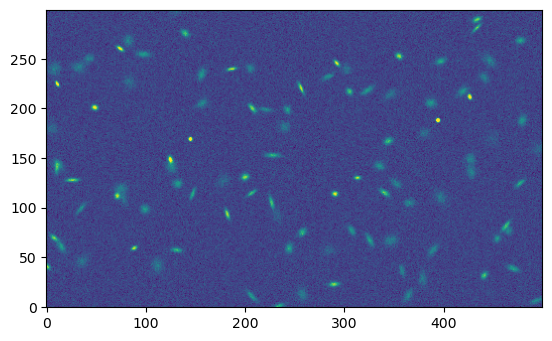

In [8]:
data = make_100gaussians_image(noise=True)
mean, median, std = sigma_clipped_stats(data, sigma=3.0)   # std is important for the right threshold when detecting point sources
print(f"Mean: {mean}\nMedian: {median}\nStd: {std}")      
plt.imshow(data, origin='lower', vmax=40)
plt.show()

## 2D Background and Noise Estimation

If the background or the background noise is not constant throughout the image, which is what you see with galactic datasets, we generate a 2D image of the background and the background RMS (aka noise). 

In [9]:
from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground

sigma_clip = SigmaClip(sigma=3.0)    # will iterate over the data, each time rejecting values
                                     # that are less or more than the specified std
bkg_estimator = MedianBackground()   # Calculate background in an array

# Estimate background and background noise
bkg = Background2D(data, (50, 50), filter_size=(3, 3),
                   sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

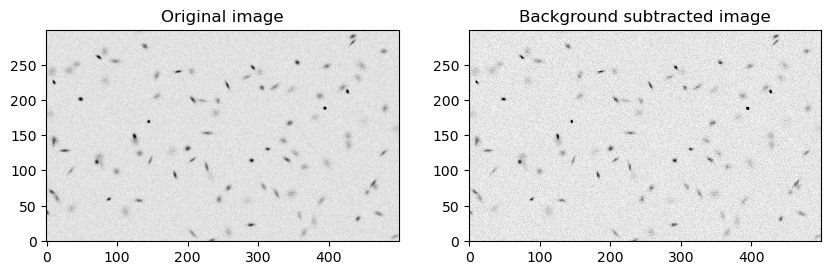

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
ax[0].imshow(data, origin='lower', vmax=40, cmap='Greys')
ax[0].set_title('Original image')
ax[1].imshow(data-bkg.background, origin='lower', cmap='Greys', interpolation='nearest', vmax=40)
ax[1].set_title('Background subtracted image')
plt.show()

This was just a few of the many options for background subtraction provided by photutils. For more information on the available options for background subtraction, see this [page](https://photutils.readthedocs.io/en/stable/user_guide/background.html#d-background-and-noise-estimation). 

# 3. Point Source Identification

Now, that we have the fwhm and we know how to estimate the background, we have the tools needed for point source identification. Let's see this with an example image.

In [11]:
from photutils.datasets import load_star_image

image = load_star_image()

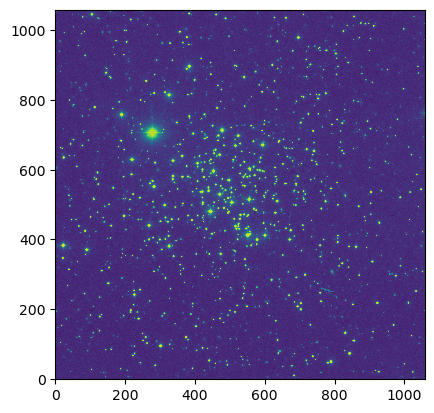

In [12]:
plt.imshow(image.data, origin='lower', interpolation='nearest')

My general strategy with point source identification of all the sources in the galaxy is to perform the point source identifcation on the subset of the image and see if the code identifies all the obvious sources in the data.

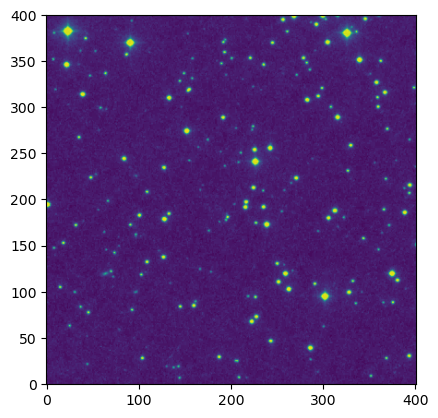

In [13]:
# Look at subset image
data = image.data[0:401, 0:401]
plt.imshow(data, origin='lower')
plt.show()

In [14]:
from photutils.detection import DAOStarFinder

mean, median, std = sigma_clipped_stats(data, sigma=3.0)       # can vary sigma depending upon the data
fwhm = 3.0
threshold= 3 * std
daofind = DAOStarFinder(fwhm=fwhm, threshold=threshold)
sources = daofind(data)
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
print(f"Found {len(positions)} sources...")

Found 466 sources...


There are many options available for the shapes of apertures. For more info on the apertures available, see this  [page](https://photutils.readthedocs.io/en/stable/user_guide/aperture.html#apertures).

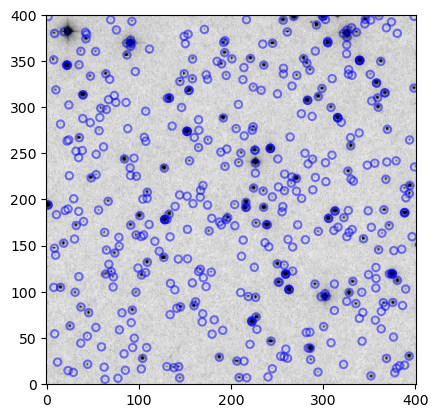

In [15]:
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture

apertures = CircularAperture(positions, r=4.0)
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(data, cmap='Greys', origin='lower', norm=norm,
           interpolation='nearest')
apertures.plot(color='blue', lw=1.5, alpha=0.5)
plt.show()

# 4. Aperture Photometry

Now, while we are at it and we have found the point sources in the image, we might as well get their photometry as well...

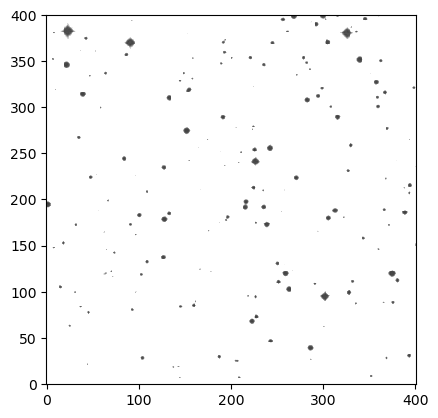

In [16]:
# Generate a background substracted image
sigma_clip = SigmaClip(sigma=5.)
bkg_estimator = MedianBackground()
bkg = Background2D(data, (50, 50), filter_size=(3, 3),
                   sigma_clip=sigma_clip,
                   bkg_estimator=bkg_estimator)
data_sub = data - bkg.background

# Take a look at the backgroudn subtracted data
plt.imshow(data_sub, cmap='Greys', origin='lower', norm=norm,
           interpolation='nearest')

A note on aperture photometry before we move on...

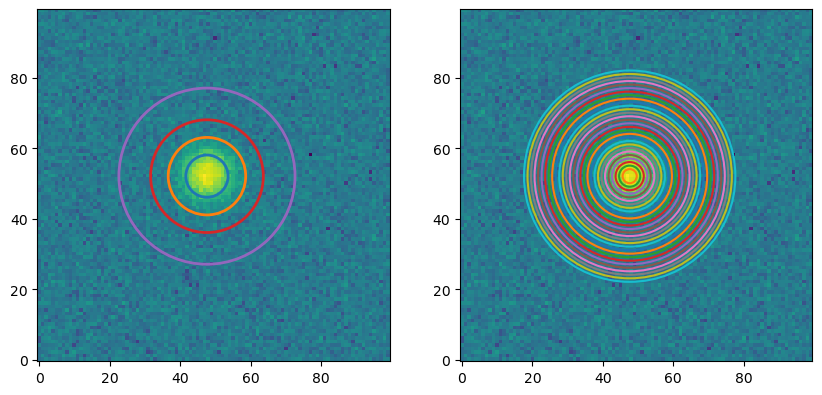

In [17]:
from starfind import make_aperture_image

make_aperture_image()

In [18]:
from photutils.aperture import aperture_photometry

ap_radii = [i for i in range(1, 31)]
apertures = [CircularAperture(positions, r=r) for r in ap_radii]

# always use background subtracted data when doing photometry
photometry = aperture_photometry(data_sub, apertures)

display(photometry)

id,xcenter,ycenter,aperture_sum_0,aperture_sum_1,aperture_sum_2,aperture_sum_3,aperture_sum_4,aperture_sum_5,aperture_sum_6,aperture_sum_7,aperture_sum_8,aperture_sum_9,aperture_sum_10,aperture_sum_11,aperture_sum_12,aperture_sum_13,aperture_sum_14,aperture_sum_15,aperture_sum_16,aperture_sum_17,aperture_sum_18,aperture_sum_19,aperture_sum_20,aperture_sum_21,aperture_sum_22,aperture_sum_23,aperture_sum_24,aperture_sum_25,aperture_sum_26,aperture_sum_27,aperture_sum_28,aperture_sum_29
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,63.22688423547722,4.881683833504825,1796.7688741583406,3408.9666733831586,4171.883745050931,5898.727396635281,7795.1999133501795,10423.057806663734,11584.638924050967,10985.406843781877,10048.459543587836,7291.571933574123,4665.81311734546,4468.510500037196,4186.092740469947,5183.635956212334,6508.191598818586,4769.5859098350265,4605.412882845887,4972.178217715938,4754.656165874145,4490.786400697678,4788.89556342445,5827.4277988611975,10733.166380376566,22686.742053856426,38466.52414983233,53265.129802757,59463.63387172573,63628.13001290376,66990.78498929791,69887.77540659485
2,77.21049654454865,6.038550592230365,1656.5692502396287,3025.847163123076,2731.369456886026,2645.09007502374,2491.2708795041935,1760.437790758273,1303.1961239731697,-360.0315409888133,-290.81510069419096,1638.3802806568715,4404.391903136535,8751.451098589803,12310.094126830925,16872.702191289532,21100.463715601505,22829.125959680736,24334.165086609282,25829.039126295895,28671.103046713924,31000.62246982962,30197.06155984596,30862.96514917437,29989.958190280355,28948.18613617027,28480.855467621295,28541.979379787386,28320.434146215157,29766.416001282632,30953.658086286436,36011.334769198984
3,144.24756716358587,6.379790427039487,17061.446782688658,37681.620831276974,47189.64272172778,53104.582680293905,58683.33955973563,63348.983130768225,65978.03226146715,65697.9755527176,69005.35868257072,73478.65343688436,79903.96406279763,100752.74638800442,135229.08928823954,159493.07523434708,168299.63180590692,174062.33827154335,180193.69392502273,185552.34997522295,192541.38319006134,194724.88164828223,191778.15464853455,187914.82857709983,183375.7762149019,183205.3453009841,183882.48613697,184907.93162342242,185157.8697782068,183452.9891931183,184293.12562635186,185760.53809207113
4,239.9444248900159,7.470755669114915,607.1020122600399,2385.759075890786,2178.766429680927,767.474388073753,1304.2405665008982,2168.127812784203,1051.8694394387462,-649.7592585753159,-2765.4967027145667,-4453.678481734675,-4296.835557943641,-4698.70443995399,-5912.174105499618,-6278.836584572467,-7293.66174239186,-11634.470798478571,-17264.428158384166,-21334.16022788997,-21885.51103354014,-22245.65361745627,-23109.55776375379,-24529.085913952782,-24535.731972198802,-24263.052037635425,-26162.135273184118,-26269.430455079288,-25406.114880052162,-24423.21845847011,-20599.091938078513,-11146.21818271511
5,208.6690686281792,6.820580537772934,20777.01839722096,50961.316813141544,64060.95060404497,70488.98592762166,76975.11311004816,82761.7694828974,86414.79086354535,89535.5198167305,92637.12058056038,93216.93831498217,94604.65953027141,95194.60930157172,94196.17760425486,93394.15393491604,93549.62596093334,93323.83026079973,100853.37390799428,124372.02765470516,152061.13391680902,165101.90911770723,169708.97879580595,172536.35140568382,174745.39438546263,174314.81177539367,173024.3873076624,172753.92119388116,173977.6915992966,179641.6414092523,192996.83635639527,225973.85694387474
6,216.92613665510058,6.57759331980456,4980.740948970812,10237.51223420184,13073.871225953639,14457.781579468512,16233.106925436443,17715.05028550786,23481.714652867144,39427.20618695281,60424.45936152878,74055.01022574407,77831.38785925599,79021.71624143806,79741.1921276260

# 5. Your turn! 

Now, this is your chance to implement the `DAOStarFinder` algorithm in another example image. 

Use the function `find_stars` below to properly detect most (if not all) the point sources in the image. Try playing around with the `fwhm` and the `std_multiple` to see how they affect your results. If the code still does not correctly identify the obvious point sources, try tweaking the `threshold` parameter then. 

In [19]:
def find_stars(data,
               fwhm,
               threshold=None, 
               sigma=5, 
               radius=5, 
               cmap='gray_r', 
               vmin=0, 
               vmax=10, 
               std_multiple=5, 
               aperture_color='#0547f9', 
               plot=True,
               photometry=True):
    """
    Find point sources in an image using the DAOStarFinder algorithm and then plot apertures 
    around the objects. If `photometry=True`, the code will return the photometric measurements as well.

    PARAMETERS
    ----------
    data : data
        Data
    fwhm : float
        Full Width at Half Maximum of a star in arcseconds. 
        This code will automatically convert the fwhm from 
        arcseconds to pixels.
    threshold : float
        If specified, it will override the threshold to be
        used for identifying stars. Otherwise, the threshold
        is used as a multiple of the standard deviation found
        through the sigma clipped statistics on the data.
    sigma : int, default=5
        sigma to be used for finding the standard deviation.
    conversion : float, default=0.031
        The convesion from arcseconds to pixel.
        Default is 0.031 for JWST NIRCam short wavelength
        filters.
    radius : float, default=5 
        Radius of the aperture to be applied on the sources
        detected. Default is 5.
    cmap : string, default='viridis'
        Colour map to be used when plotting the image. Default 
        is viridis. 
    aperture_color : string, default='limegreen'
        The color of the apertures.

    RETURN
    ------
    positions : np.arrays
        The positions of the point sources.
        Also plots the apertures around the point 
        sources on the image. 
        """
    mean, median, std = sigma_clipped_stats(data, sigma=sigma)

    # If threshold is provided manually.
    if threshold:
        daofind = DAOStarFinder(fwhm=fwhm, threshold=threshold)
        objects = daofind(data)
    else:
        daofind = DAOStarFinder(fwhm=fwhm, threshold=std_multiple*std)
        objects = daofind(data)

    print("Found", len(objects), "objects.")
    positions = np.transpose((objects["xcentroid"], objects["ycentroid"]))

    # Create apertures around sources
    if plot:
        apertures = CircularAperture(positions, r=radius)
        plt.imshow(data,
                   cmap=cmap, 
                   vmin=vmin, 
                   vmax=vmax, 
                   origin='lower',
                   interpolation='nearest')
        apertures.plot(color=aperture_color)
        plt.show()

    if photometry:
        # Generate a background substracted image
        sigma_clip = SigmaClip(sigma=5.)
        bkg_estimator = MedianBackground()
        bkg = Background2D(data, (50, 50), filter_size=(3, 3),
                        sigma_clip=sigma_clip,
                        bkg_estimator=bkg_estimator)
        data_sub = data - bkg.background
        photometry = aperture_photometry(data_sub, apertures)
        print("displaying photometry")
        display(photometry)


Found 269 objects.


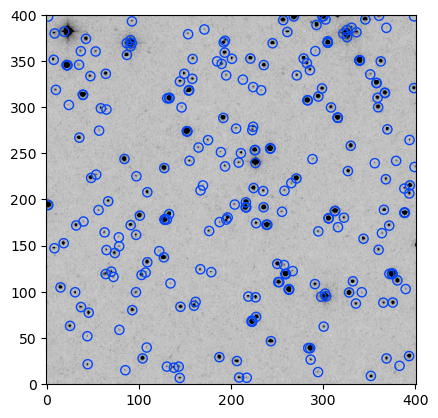

displaying photometry


id,xcenter,ycenter,aperture_sum
int64,float64,float64,float64
1,144.24756716358587,6.379790427039487,58683.33955973563
2,208.6690686281792,6.820580537772934,76975.11311004816
3,216.92613665510058,6.57759331980456,16233.106925436443
4,351.6251903825918,8.545901323298798,63762.51522225358
5,294.2728404665307,12.737191250825386,20027.401537016154
6,85.21772831944668,14.710346834511743,7290.947708768636
7,137.94128566136274,17.46471840389003,68843.94252246362
8,130.32797244529527,18.678087427830548,27455.52955795027
9,143.1104993046545,18.623553071389225,76563.97435289665


In [20]:
stars = find_stars(data,
           fwhm=3.0,
           std_multiple=5.,
           photometry=True,
           cmap='Greys',
           vmax=10000)

In [21]:
# Run this cell to load dataset
# it might take a few seconds
from photutils.datasets import load_spitzer_image

spitzer_image = load_spitzer_image()

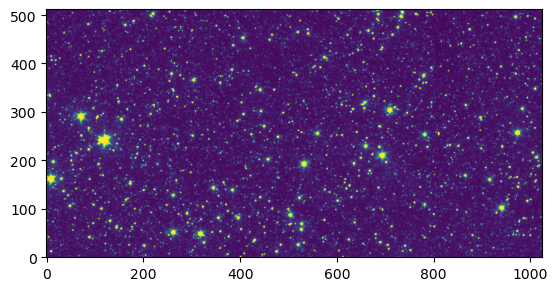

In [22]:
# Run this cell to print the data image
plt.imshow(spitzer_image.data, origin='lower', vmax=65)

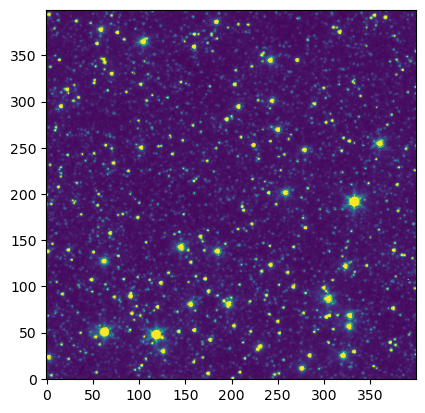

In [23]:
# Remember to analyse the subset of the image first

# Plot subset image
subset = spitzer_image.data[0:400, 200:600]
plt.imshow(subset, origin='lower', vmax=65, cmap='viridis')
plt.show()

Found 824 objects.


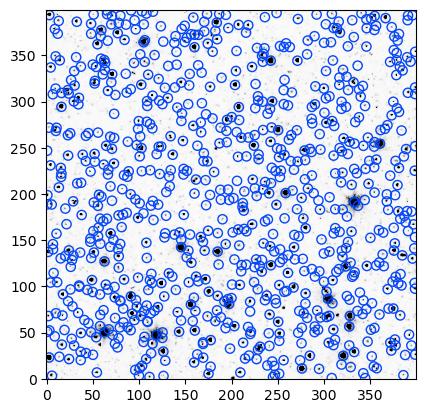

displaying photometry


id,xcenter,ycenter,aperture_sum
int64,float64,float64,float64
1,308.3612014578167,0.8009680336885849,117.79298948750134
2,244.78573753070748,1.849694718683962,1274.3465532907203
3,344.58427920957246,0.7307528639772614,131.658831158069
4,111.10016720047018,1.9843578860128621,229.83053315395787
5,5.588263083756452,3.336644677860838,1117.5551347011988
6,99.73852188281398,3.3224430388518904,201.2974817823908
7,126.30458477320435,3.0732248181143027,174.20757018389335
8,246.77583695423047,4.340376692543062,1706.055282178228
9,385.90620850073117,3.8841983404622695,112.22579204379416


In [24]:
# First try setting fwhm somewhere around 10 and see what you get and go from there
find_stars(subset, 
            fwhm=2.75,
            std_multiple=5,    # comment if using threshold
           # threshold=,       # comment if using std_multiple
           cmap='Greys', 
           vmax=60)

# 6. Use cases of the `DAOStarFinder` algorithm

1. X-ray binary identification. 
2. Cataloging and astrometry of astronomical sources.
3. Identification of point sources in a galaxy.
    1. Identification of star clusters to study gas and star formation -- [Phangs Collaboration](https://sites.google.com/view/phangs/home)
4. Identification of galaxies ([skyviewer](https://skyviewer.app/explorer))
5. Identification and cataloging of asteroids in the asteroid belts.

There's so much science possible with this! With just basic photometry, we can investigate (or estimate) so many additional properties of these astronomical objects, their nature, their mass, their ages, their environment! The possibilities are 'astronomically' endless!